# Examen Simulación
## Realizado por René Panjón
    • La empresa ABC-TURISMO desea saber si tiene los recursos necesarios para soportar la demanda de los usuarios. En base a ello, diseñe y desarrolle un modelo y/o script que permita realizar la simulación de movilizaciones de personas desde un lugar del Ecuador a otro para la empresa de turismo de venta de tickets y ver si el número de buses darán soporte:

            ▪ Investigar en número de personas que se movilizan, y los lugares de mayor afluencia, principalmente del Azuay.
            ▪ El número de buses son 10 con 40 pasajeros cada uno.
            ▪ Generar un nombre de la persona y el género(Bernoulli), y la edad adultos (Poison) aleatoriamente.
            ▪ Un usuario realiza la compra de un boleto desde un lugar de origen a un destino.
            ▪ Se agrega la posición de partida latitud y longitud y de llegada.
            ▪ Se agrega el tiempo de la compra la misma que tiene una distribución de probabilidad normal con media de 10 minutos y desviación estándar de 2 minutos.
            ▪ Cada día sale un bus cada hora, una vez que el bus sale no pueden subir, hasta que llegue a la parada, regresa el bus el mismo tiempo que se demora en llegar al destino.
            ▪ Agregar graficas/reportes
                • Venta de tickets.
                • Lugares de origen y destino más visitados.
                • Numero de buses necesarios y el uso del mismo diarios

### Investigación
Para el 11 de Octubre del 2020, 82835 personas vistaron las playas durante ese feriado que tuvo duración de tres dias, 
siendo esto apenas un 40% de la cantidad que se suscitaba en feriados antes del COVID, para esta simulación se tomó 
el mismo número de personas, teniendo en cuenta que aún está presente la pandemia y es un buen número obtenido deee estadisticas reales.

Referencia: https://www.elcomercio.com/actualidad/ecuador/turistas-playas-balance-feriado-emergencias.html

Según El Comercio, las playas más visitadas son: Playas Villamil, Atacames, Montañita, Crucita y otras seis playas, de las cuales se tomará 4 ubicaciones para la simulación

Referencia: https://www.elcomercio.com/tendencias/sociedad/ecuador-turismo-playas-restricciones-turistas.html

In [331]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/eugeny/tabby/pypi/simple


In [332]:
import collections
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats 
import seaborn as sns 
from random import randint
from simpy.events import Timeout
import collections
import random
import simpy
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats 
import seaborn as sns 
from random import randint
from simpy.events import Timeout

### Base de Datos de nombres

In [333]:
male_names = pd.read_csv('./names_male.csv')
female_names = pd.read_csv('./names_female.csv')
print(male_names.head(2),'\n ',female_names.head(2))

  GivenName
0     James
1   Antoine 
    GivenName
0   Barbara
1     Wendy


Uso de Distribución de Bernoulli para obtener un género.

In [334]:
# Bernoulli
def get_random_gender_with_bernoulli():
    p = 0.4  # parametro de forma
    bernoulli = stats.bernoulli(p)
    return bernoulli.rvs(1)[0]  # 1->Hombre 0->Mujer

Función para obtener un nombre aleatorio según el género.

In [335]:
def get_random_name_by_gender(gender):
    if(gender == 1):
        random_name = male_names['GivenName'][random.randint(0, 99)]
        return random_name
    else:
        random_name = female_names['GivenName'][random.randint(0, 99)]
        return random_name

Uso de Distribución de Poisson para obtener una edad aleatoria.

In [336]:
def get_random_age_with_poisson():
    mu = 40  # parametro de forma
    poisson = stats.poisson(mu)  # Distribución
    return poisson.rvs(1)[0]  # genera aleatorios

Función para generar un cliente random

In [337]:
def create_random_client():
    gender = get_random_gender_with_bernoulli()
    name = get_random_name_by_gender(gender)
    age = get_random_age_with_poisson()
    return {'name': name, 'age': age, 'genre': 'Male' if gender==1 else 'Female'}

Función para calcular tiempo de compra de ticket

In [338]:
def calculate_shopping_time(): 
  mu, sigma = 10, 2
  normal = stats.norm(mu, sigma)
  return normal.rvs(1)[0]

 Información de destinos y buses

In [339]:
ORIGIN_PLACE = ['Terminal Cuenca', 'Terminal Gualaceo', 'Terminal Azogues']
DESTINATION_PLACE = [{'destination': 'Playa Murcielago', 'latitude': '-0.9380124', 'longitude': '-80.7316374', 'time': 20680},
                      {'destination': 'Villamil Playas', 'latitude': '-2.1636688','longitude': '-79.9062907', 'time': 12600},
                      {'destination': 'Montañita', 'latitude': '-1.8261141','longitude': '-80.7577205', 'time': 21600},
                      {'destination': 'Playa Bajo Alto', 'latitude': '-3.1049131', 'longitude': '-79.9031618', 'time': 12672}]
BUSES = [ {'id': '001', 'destination': 'Playa Murcielago'},
          {'id': '002', 'destination': 'Playa Murcielago'},
          {'id': '003', 'destination': 'Villamil Playas'},
          {'id': '004', 'destination': 'Villamil Playas'},
          {'id': '005', 'destination': 'Montañita'},
          {'id': '006', 'destination': 'Montañita'},
          {'id': '007', 'destination': 'Playa Bajo Alto'},
          {'id': '008', 'destination': 'Playa Murcielago'},
          {'id': '009', 'destination': 'Montañita'},
          {'id': '010', 'destination': 'Villamil Playas'},
        ]



Simulación de evento

In [340]:
TRAVEL_AGENCY = 1
NUMBER_OF_BUSES = 10
NUMBER_OF_SEATS = 40
DAYS = 4
SIMULATION_TIME = 86400 * DAYS

In [341]:
class Travel_Agency(): 
  def __init__(self, env):
    self.env = env
    self.bus_fleet = simpy.Resource(env, capacity=NUMBER_OF_BUSES)
    self.agency = simpy.Resource(env, capacity=TRAVEL_AGENCY)
    self.destinations = DESTINATION_PLACE
    self.buses = BUSES
    self.ticket_office = {'tickets':[],'number_of_rejected':0}
    self.initialize()
    self.dispatch = env.process(self.dispatch_bus())
        
  def initialize(self):
    for bus in self.buses:
      bus['container'] = simpy.Container(env, init=NUMBER_OF_SEATS, capacity=NUMBER_OF_SEATS)
      bus['sold_out'] = env.event()
      bus['time_out'] = None
    
  def dispatch_bus(self):
    while True:
      with self.bus_fleet.request() as transport:
        yield transport
        for ticket in self.ticket_office['tickets']:
            destinations = list(filter(lambda destination: destination['destination'] == ticket["bus"]["destination"], self.destinations))[0]
            bus = list(filter(lambda bus: bus['id'] == ticket["bus"]["id"], self.buses))[0]
            yield env.timeout(3600) # Partir cada hora
            id = ticket["bus"]['id']
            destination = ticket["bus"]['destination']
            passengers = NUMBER_OF_SEATS - bus["container"].level
            print(f'Partió el bus N° {id} hacíá el destino "{destination}" con {passengers} pasajeros')
            self.env.process(self.bus_return())
            
  def bus_return(self):
    while True:
      with self.bus_fleet.request() as transport:
        yield transport
        for ticket in self.ticket_office['tickets']:
            destinations = list(filter(lambda destination: destination['destination'] == ticket["bus"]["destination"], self.destinations))[0]
            bus = list(filter(lambda bus: bus['id'] == ticket["bus"]["id"], self.buses))[0]
            yield env.timeout(destinations["time"])
            yield bus["container"].put(NUMBER_OF_SEATS)
            id = ticket["bus"]['id']
            passengers = NUMBER_OF_SEATS - bus["container"].level
            print(f'Retorna el bus N° {id} con {passengers} pasajeros') 
            self.bus_fleet.release(transport)
            
  def buy_ticket(self, client):
    with self.agency.request() as agency:
      resultado = yield agency
      shopping_time = calculate_shopping_time()
      buses = list(filter(lambda bus: bus['destination'] == client["destination"], self.buses))
      for bus in buses:
        if bus["container"].level < client["purchased_tickets"]:
          yield env.timeout(0.5) 
          continue
        
        bus["container"].get(client["purchased_tickets"])
        ticket = {
            "client": client,
            "destination":list(filter(lambda destino: destino['destination'] == client["destination"], self.destinations))[0],
            "bus":bus,
            "shopping_time": shopping_time
        }
        self.ticket_office["tickets"].append(ticket)

        print('Boleto No %s, comprado por %s, al destino %s, bus desigano N° %s, capacidad restante %s' %(str(client["purchased_tickets"]), ticket["client"]["name"], ticket["destination"]["destination"], ticket["bus"]["id"], str(bus["container"].level)))
        break
      yield env.timeout(shopping_time)
      self.agency.release(agency) 

  def arrive_client(self):
    for i in range(82835):
      destination = random.choice(self.destinations)
      client = create_random_client()
      client["purchased_tickets"] = random.randint(1, 5)
      client["destination"] = destination["destination"]
      
      env.process(self.buy_ticket(client))
      yield env.timeout(1)


In [342]:
env = simpy.Environment()
agency = Travel_Agency(env)
generated = env.process(agency.arrive_client())
env.run(until=SIMULATION_TIME)

Boleto No 4, comprado por Anna, al destino Playa Bajo Alto, bus desigano N° 007, capacidad restante 36
Boleto No 3, comprado por Logan, al destino Villamil Playas, bus desigano N° 003, capacidad restante 37
Boleto No 4, comprado por Connie, al destino Villamil Playas, bus desigano N° 003, capacidad restante 33
Boleto No 4, comprado por Irene, al destino Villamil Playas, bus desigano N° 003, capacidad restante 29
Boleto No 4, comprado por Shanon, al destino Montañita, bus desigano N° 005, capacidad restante 36
Boleto No 5, comprado por Jon, al destino Villamil Playas, bus desigano N° 003, capacidad restante 24
Boleto No 4, comprado por Donald, al destino Playa Murcielago, bus desigano N° 001, capacidad restante 36
Boleto No 4, comprado por Angela, al destino Playa Bajo Alto, bus desigano N° 007, capacidad restante 32
Boleto No 2, comprado por James, al destino Playa Bajo Alto, bus desigano N° 007, capacidad restante 30
Boleto No 2, comprado por Kathryn, al destino Playa Bajo Alto, bus d

# Gráficas

12245


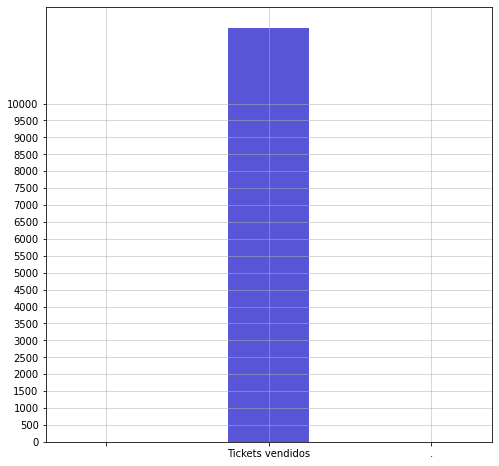

In [343]:
print(len(agency.ticket_office['tickets']))
plt.figure(figsize=(8,8))
plt.bar([ '', 'Tickets vendidos', '.'], [0,len(agency.ticket_office['tickets']),0], color='#5856d6', width=0.5)
plt.yticks(np.arange(0, 10001, 500))
plt.grid(linestyle='-', linewidth=0.5)
plt.show()


Destinos más visitados

4475 1402 1802 4566


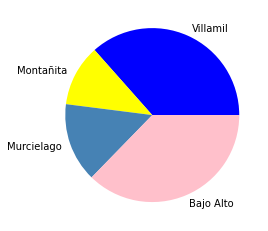

In [344]:
destinations = [ticket['destination']['destination'] for ticket in agency.ticket_office['tickets']]
# for destination in destinations:
#   if destination == 'Villamil Playas':
villamil = destinations.count('Villamil Playas')
murcielago = destinations.count('Playa Murcielago')
montañita = destinations.count('Montañita')
bajo_alto = destinations.count('Playa Bajo Alto')
# print(destinations)
print(villamil, montañita, murcielago, bajo_alto)
colors = ['blue', 'yellow', 'steelblue', 'pink']
labels = ['Villamil', 'Montañita', 'Murcielago', 'Bajo Alto']
plt.pie([villamil, montañita, murcielago, bajo_alto], colors=colors,labels=labels)
plt.show()

Personas que se quedaron sin boleto

70590


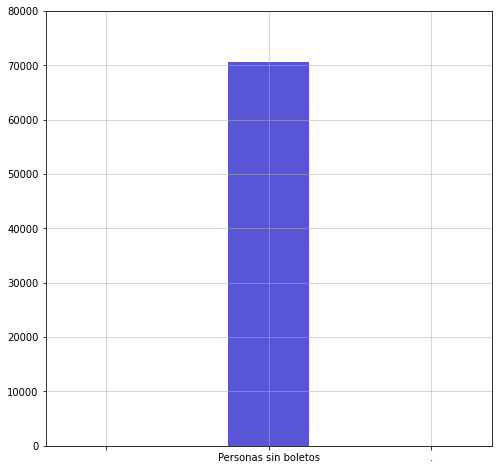

In [345]:
print(82835 - len(agency.ticket_office['tickets']))
plt.figure(figsize=(8,8))
plt.bar([ '', 'Personas sin boletos', '.'], [0,(82835 - len(agency.ticket_office['tickets'])),0], color='#5856d6', width=0.5)
plt.yticks(np.arange(0, 90000, 10000))
plt.grid(linestyle='-', linewidth=0.5)
plt.show()

Tiempo total demorado en comprar boletos

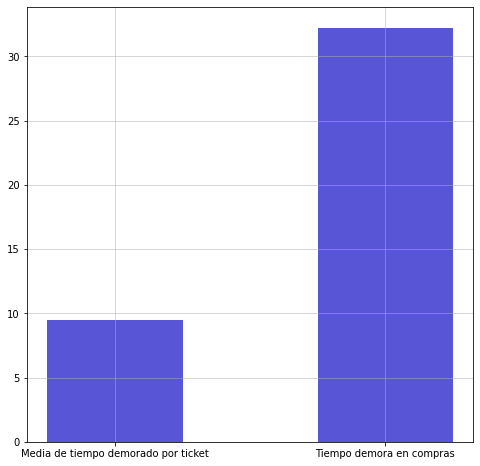

In [346]:
avg_time_ticket = [ticket['shopping_time'] for ticket in agency.ticket_office['tickets']]

total = ((sum(avg_daily_ticket)/60)/60) 
mean_ticket = sum(avg_daily_ticket) / len(agency.ticket_office['tickets'])

plt.figure(figsize=(8,8))
plt.bar([ 'Media de tiempo demorado por ticket', 'Tiempo demora en compras',], [mean_ticket,total], color='#5856d6', width=0.5)
# plt.yticks(np.arange(0, 100, 10))
plt.grid(linestyle='-', linewidth=0.5)
plt.show()